# WMH Segmentation Data Preparation

1. Dataset download
2. Preprocessing of FLAIR and T1 images
3. Data visualization

## Setup

### Install Dependencies

In [ ]:
!pip install nibabel nipype monai scipy numpy matplotlib

### Install FSL

In [ ]:
# Download FSL installer
!curl -O https://fsl.fmrib.ox.ac.uk/fsldownloads/fslinstaller.py

# Run the installer
!python fslinstaller.py

# Add FSL to PATH
# FSL Setup
!export FSLDIR=/usr/local/fsl
!source ${FSLDIR}/etc/fslconf/fsl.sh
!export PATH=${FSLDIR}/bin:$PATH

# Test the installation
!bet -h

### Import Libraries

In [2]:
import os
import sys
from pathlib import Path
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Define data root
DATA_ROOT = Path('/Users/hsuh/Gitrepo/SwitchSite/1.data/MICCAI-2017')

## Data Download


In [ ]:
from download import get_metadata, download_dataset 

# Get metadata
miccai_metadata = get_metadata()

# Download dataset
download_dataset(miccai_metadata, DATA_ROOT)


Downloading: 100%|██████████| 1791/1791 [00:00<00:00, 56776.17file/s]


**From the MICCAI-2017 readme.pdf**

### Folder: orig

This folder contains the original images, anonimized and having the face removed. The mask used to remove the face from the 3D T1 images is provided. The 3D T1 image has been aligned with the FLAIR image using elastix 4.8 with the following parameter file: elastix parameter file for the WMH Segmentation Challenge.

### Folder: pre
All images were pre-processed with SPM12 r6685 to correct bias field inhomogeneities.

### Manual reference standard

This file is only provided for the training data and it contains the following three labels:

0. Background
1. White matter hyperintensities
2. Other pathology

The objective of this challenge is to automatically segment WMH. Because we do not require methods to identify all other types of pathology, we provide a rough mask for them that will be ignored during evaluation.

## Visualization Functions

In [3]:
from matplotlib.colors import LinearSegmentedColormap
# Create a custom colormap that goes from black to red
colors = [(0, 0, 0, 0), (1, 0, 0, 1)]  # transparent black to solid red
custom_cmap = LinearSegmentedColormap.from_list('custom', colors)

default_slices [24, 120, 120]

Image Statistics:
Shape: (240, 240, 48)
Voxel spacing (mm): [0.95833331 0.95833334 2.99999717]
Intensity range: [0.00, 2621.00]
Mean intensity: 186.57
Standard deviation: 332.68


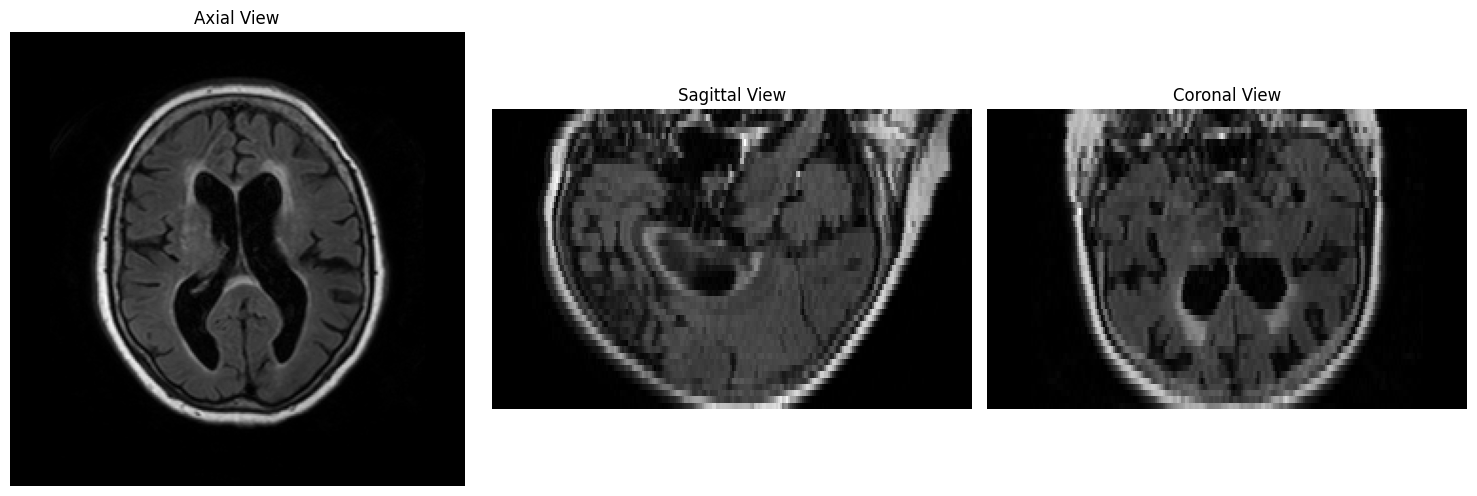

In [37]:
def show_image(img, mask=None, title="", slice_idx_list=None, pixel_spacing=None):
    """
    Plot three orthogonal views of the image with optional mask overlay
    img: 3D numpy array of the image
    mask: Optional 3D numpy array of the mask
    title: Optional title for the figure
    """

    img_data = img.get_fdata()
    mask_data = mask.get_fdata() if mask is not None else None

    # Get middle slices or use provided indices
    default_slices = [img.shape[2]//2, img.shape[1]//2, img.shape[0]//2]
    print('default_slices', default_slices)
    slice_idx_list = default_slices if slice_idx_list is None else [
        s if s is not None else d for s, d in zip(slice_idx_list, default_slices)
    ]
    
    # Calculate pixel spacing from affine if available
    if pixel_spacing is None:
        if hasattr(img, 'affine'):
            pixel_spacing = np.array([
                np.sqrt(np.sum(img.affine[:3, 0] ** 2)),
                np.sqrt(np.sum(img.affine[:3, 1] ** 2)),
                np.sqrt(np.sum(img.affine[:3, 2] ** 2))
            ])
        else:
            print("No affine matrix found for the image.")
            pixel_spacing = np.array([1.0, 1.0, 3.0])  # Default to isotropic if no affine

    # Create figure
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    plt.suptitle(title)

    # Plot axial view (x-y plane)
    ax1.imshow(img_data[:, :, slice_idx_list[0]].T, cmap='gray',
               aspect=pixel_spacing[1]/pixel_spacing[0])
    if mask is not None:
        ax1.imshow(mask_data[:, :, slice_idx_list[0]].T, alpha=0.3, cmap=custom_cmap,
                  aspect=pixel_spacing[1]/pixel_spacing[0])
    ax1.set_title('Axial View')
    ax1.axis('off')

    # Plot sagittal view (y-z plane)
    ax2.imshow(img_data[slice_idx_list[2], :, :].T, cmap='gray',
               aspect=pixel_spacing[2]/pixel_spacing[1])
    if mask is not None:
        ax2.imshow(mask_data[slice_idx_list[2], :, :].T, alpha=0.3, cmap=custom_cmap,
                  aspect=pixel_spacing[2]/pixel_spacing[1])
    ax2.set_title('Sagittal View')
    ax2.axis('off')

    # Plot coronal view (x-z plane)
    ax3.imshow(img_data[:, slice_idx_list[1], :].T, cmap='gray',
               aspect=pixel_spacing[2]/pixel_spacing[0])
    if mask is not None:        
        ax3.imshow(mask_data[:, slice_idx_list[1], :].T, alpha=0.3, cmap=custom_cmap,
                  aspect=pixel_spacing[2]/pixel_spacing[0])
    ax3.set_title('Coronal View')
    ax3.axis('off')

    plt.tight_layout()
    
    # Print statistics
    print(f"\nImage Statistics:")
    print(f"Shape: {img_data.shape}")
    print(f"Voxel spacing (mm): {pixel_spacing}")
    print(f"Intensity range: [{np.min(img_data):.2f}, {np.max(img_data):.2f}]")
    print(f"Mean intensity: {np.mean(img_data):.2f}")
    print(f"Standard deviation: {np.std(img_data):.2f}")
    
    plt.show()

test_flair_img = nib.load(str( DATA_ROOT / 'test/Utrecht/28/orig/FLAIR.nii.gz' ))
show_image(test_flair_img)

default_slices [96, 128, 128]

Image Statistics:
Shape: (256, 256, 192)
Voxel spacing (mm): [1. 1. 1.]
Intensity range: [0.00, 5122.00]
Mean intensity: 233.78
Standard deviation: 438.62


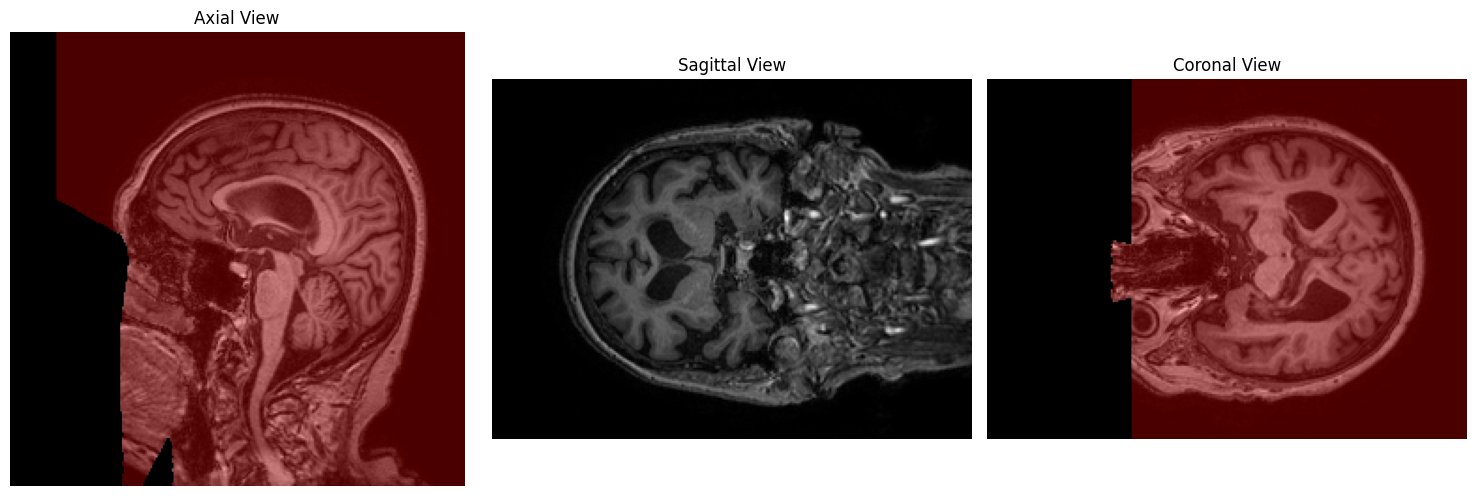

In [32]:
test_t1_img = nib.load(str( DATA_ROOT / 'test/Utrecht/28/orig/3DT1.nii.gz' ))
test_t1_mask = nib.load(str( DATA_ROOT / 'test/Utrecht/28/orig/3DT1_mask.nii.gz' ))
show_image(test_t1_img, test_t1_mask)

default_slices [24, 120, 120]

Image Statistics:
Shape: (240, 240, 48)
Voxel spacing (mm): [0.95833331 0.95833334 2.99999717]
Intensity range: [0.00, 2621.00]
Mean intensity: 186.57
Standard deviation: 332.68


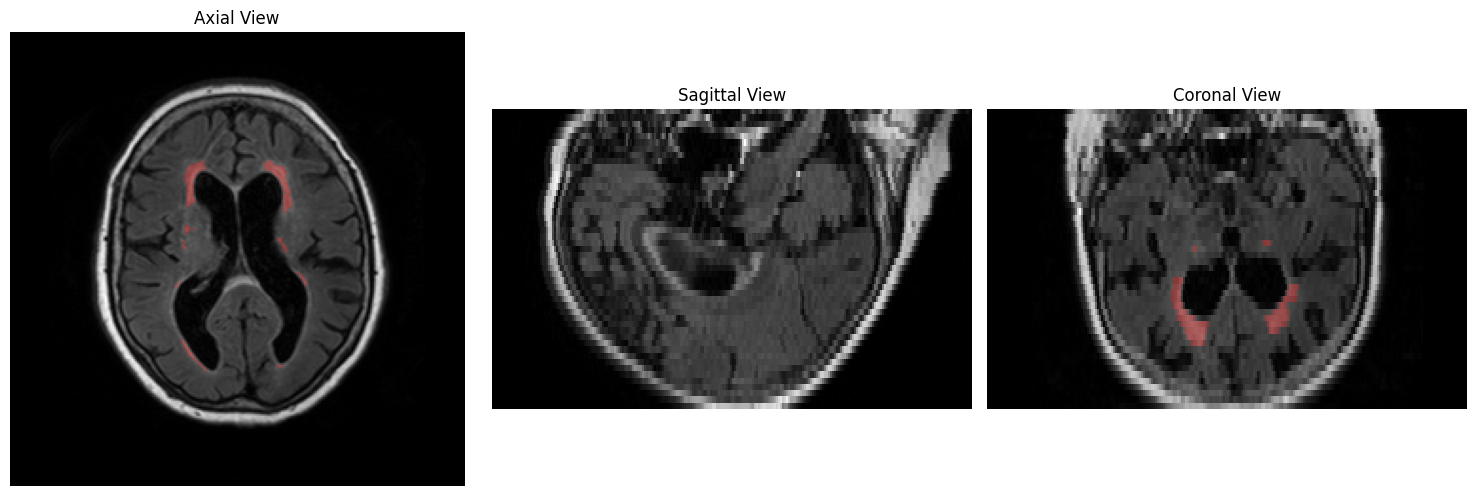

In [33]:
wmh_img = nib.load(str( DATA_ROOT / 'test/Utrecht/28/wmh.nii.gz' ))
show_image(test_flair_img,wmh_img)

default_slices [96, 128, 128]

Image Statistics:
Shape: (256, 256, 192)
Voxel spacing (mm): [1. 1. 1.]
Intensity range: [0.00, 4999.38]
Mean intensity: 230.32
Standard deviation: 429.55


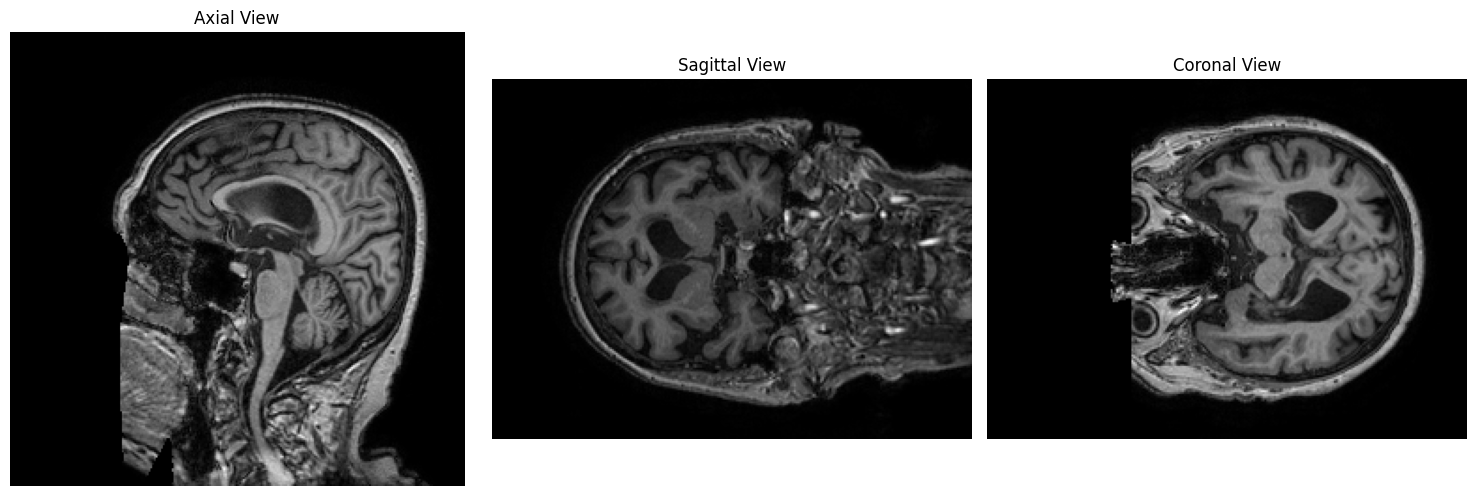

In [34]:
pre_3dt1_img = nib.load(str( DATA_ROOT / 'test/Utrecht/28/pre/3DT1.nii.gz' ))
show_image(pre_3dt1_img)

default_slices [24, 120, 120]

Image Statistics:
Shape: (240, 240, 48)
Voxel spacing (mm): [0.95833331 0.95833334 2.99999717]
Intensity range: [0.00, 3391.00]
Mean intensity: 271.50
Standard deviation: 445.50


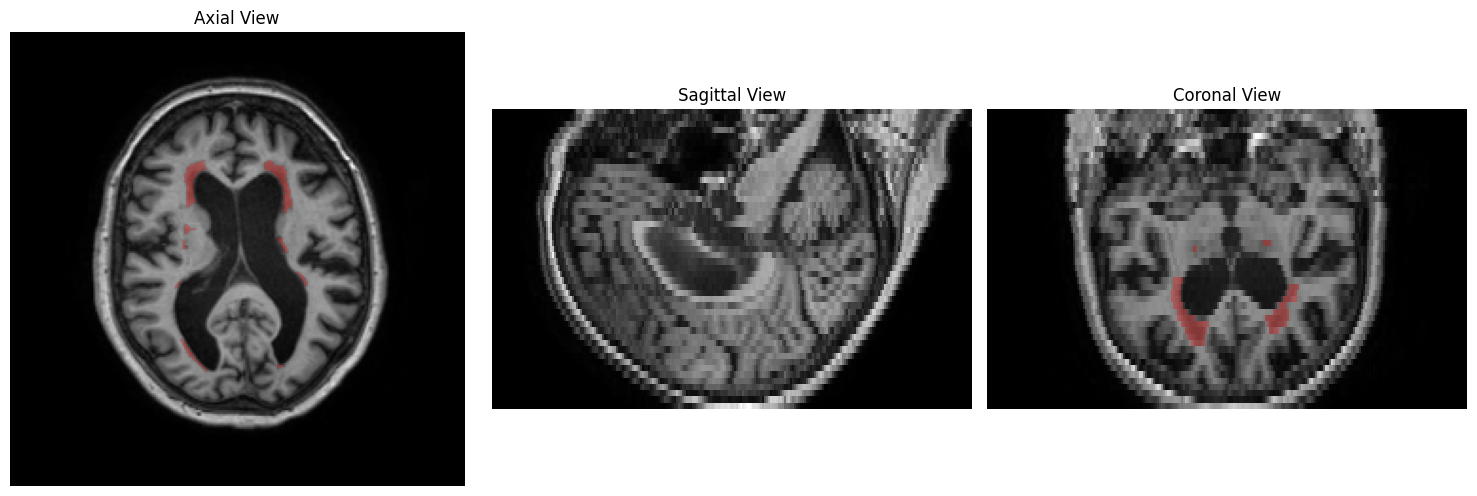

In [35]:
pre_t1_img = nib.load(str( DATA_ROOT / 'test/Utrecht/28/pre/T1.nii.gz' ))
show_image(pre_t1_img, wmh_img)

## Process Dataset

### Import Preprocessing Functions

In [8]:
!export FSLOUTPUTTYPE=NIFTI

In [9]:
from preprocess import WMHPreprocessor

preprocessor = WMHPreprocessor(DATA_ROOT)

### Test Preprocessing

In [10]:
# Test with a single file
os.environ['FSLOUTPUTTYPE'] = 'NIFTI'

test_flair_file = DATA_ROOT / 'training/Amsterdam/GE3T/100/pre/FLAIR.nii.gz'
test_falir_file_output = DATA_ROOT / 'training/Amsterdam/GE3T/100/pre2/FLAIR.nii.gz'
preprocessor.process_single_file(test_flair_file, test_falir_file_output)

test_t1_file = DATA_ROOT / 'training/Amsterdam/GE3T/100/pre/T1.nii.gz'
test_t1_file_output = DATA_ROOT / 'training/Amsterdam/GE3T/100/pre2/T1.nii.gz'
preprocessor.process_single_file(test_t1_file, test_t1_file_output)

Original spacing: (1.2, 0.97659993, 3.0)
Error processing /Users/hsuh/Gitrepo/SwitchSite/1.data/MICCAI-2017/training/Amsterdam/GE3T/100/pre/FLAIR.nii.gz: [Errno 2] No such file or directory: '/Users/hsuh/Gitrepo/SwitchSite/1.data/MICCAI-2017/training/Amsterdam/GE3T/100/pre2/FLAIR.nii.gz'
Original spacing: (1.2, 0.9766, 3.0)
Error processing /Users/hsuh/Gitrepo/SwitchSite/1.data/MICCAI-2017/training/Amsterdam/GE3T/100/pre/T1.nii.gz: [Errno 2] No such file or directory: '/Users/hsuh/Gitrepo/SwitchSite/1.data/MICCAI-2017/training/Amsterdam/GE3T/100/pre2/T1.nii.gz'


default_slices [24, 120, 120]

Image Statistics:
Shape: (240, 240, 48)
Voxel spacing (mm): [0.95833331 0.95833334 2.99999717]
Intensity range: [0.00, 2621.00]
Mean intensity: 186.57
Standard deviation: 332.68


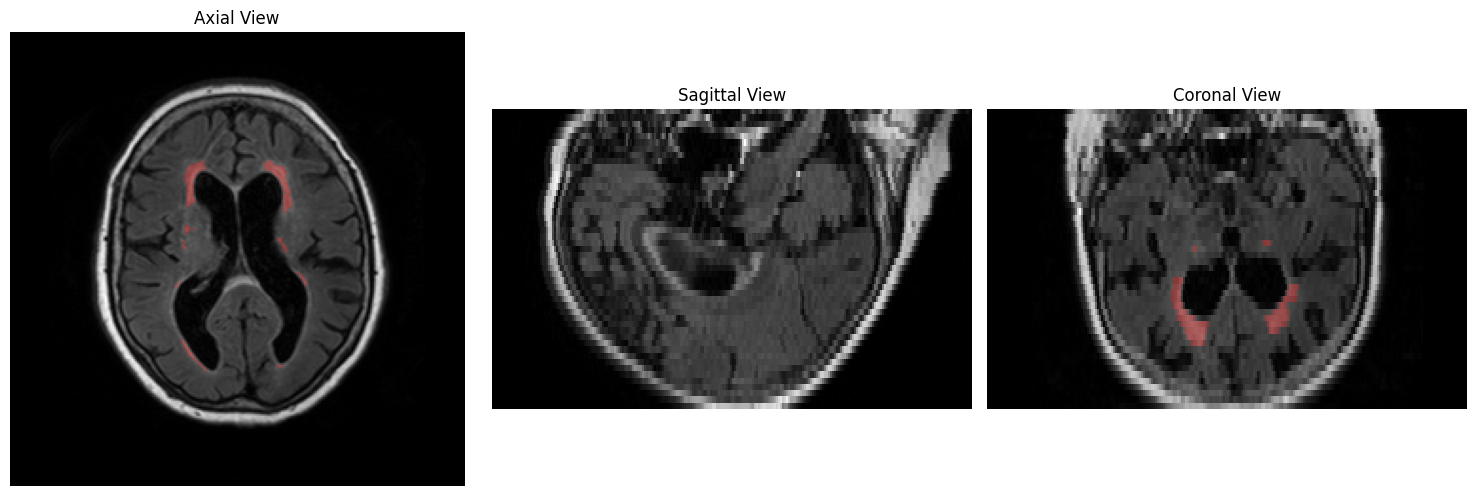

default_slices [24, 120, 120]

Image Statistics:
Shape: (240, 240, 48)
Voxel spacing (mm): [0.95833331, 0.95833334, 2.99999717]
Intensity range: [-2.05, 6.35]
Mean intensity: 0.00
Standard deviation: 0.43


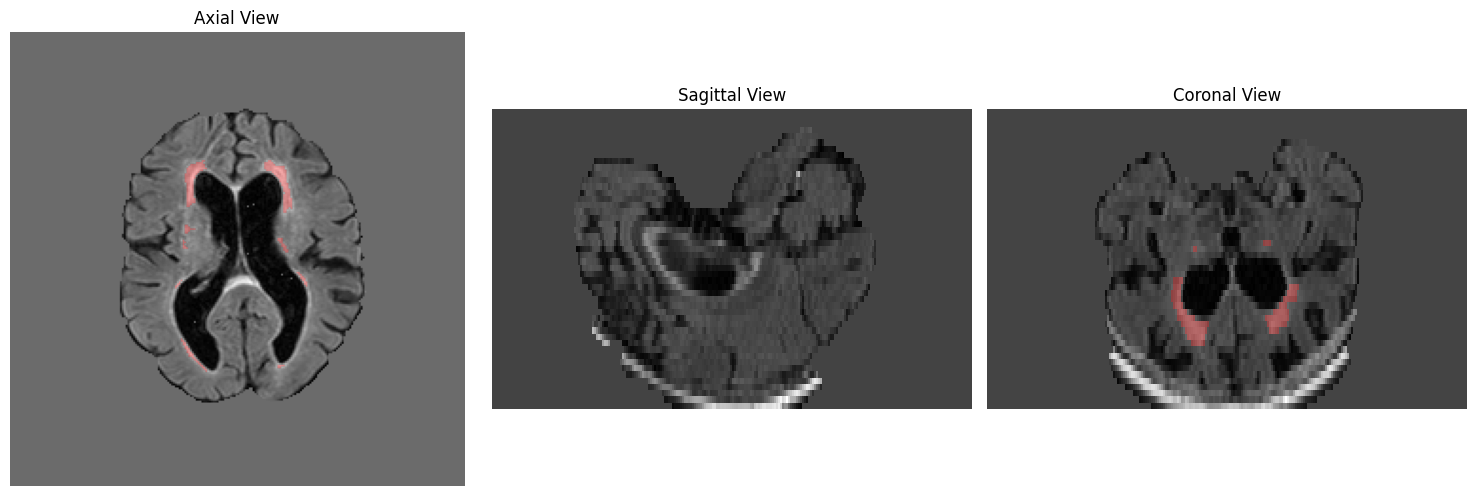

In [39]:

# Process first subject for demonstration
# test_subject = next(DATA_ROOT.glob('**/1*'))
test_flair_pre2_img = nib.load(str( DATA_ROOT / 'test/Utrecht/28/pre2/FLAIR.nii.gz' ))
test_flair_pre2_img.header.get_zooms()

# Show comparison
show_image(test_flair_img, wmh_img)
show_image(test_flair_pre2_img, wmh_img, pixel_spacing=[0.95833331, 0.95833334, 2.99999717])

# Print statistics
# print(f"Original FLAIR stats: mean={np.mean(orig_flair):.2f}, std={np.std(orig_flair):.2f}")
# print(f"Processed FLAIR stats: mean={np.mean(proc_flair):.2f}, std={np.std(proc_flair):.2f}")

## Process Full Dataset

In [ ]:
# Process all subjects
preprocessor.process_dataset()